# Project Tanzania Tourism Prediction

The objective of this hackathon is to develop a machine learning model to predict what a tourist will spend when visiting Tanzania.The model can be used by different tour operators and the Tanzania Tourism Board to automatically help tourists across the world estimate their expenditure before visiting Tanzania.


**Value of the Project:**
- Help future tourists estimate their expected expenditure before visiting Tanzania 
- enabling the Tanzania Tourism Board and tour operators to provide instant cost insights and better planning tools


**Evaluation Metric:** 
- MAE (Mean Absolute Error): --> Measures the average absolute difference between predicted and actual spending (lower = better)


**Project Goals:** 
- Minimize prediction error (lower MAE and RMSE).


**Baseline Model:** 
- Linear Regression (no feature engineering yet)


**Target Baseline Score:**
-  MAE < 1,000,000 TZS (Tanzanian Shilling) 
- 1 Tanzanian Shilling (TZS) = 100 cents

# Import

In [27]:
import os

import numpy as np
import pandas as pd

from scipy.stats import skew
from scipy import stats
from scipy.stats import norm
from timeit import default_timer as timer


# Modelling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format
import warnings
warnings.filterwarnings('ignore')

RSEED = 42

# Getting the Data

In [28]:
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')

In [29]:
train.head()


,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.00,1.00,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,No,13.00,0.00,Cash,No,Friendly People,"674,602.50"
1,tour_10,UNITED KINGDOM,25-44,NaN,1.00,0.00,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,14.00,7.00,Cash,Yes,"Wonderful Country, Landscape, Nature","3,214,906.50"
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.00,1.00,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,No,1.00,31.00,Cash,No,Excellent Experience,"3,315,000.00"
3,tour_1002,UNITED KINGDOM,25-44,Spouse,1.00,1.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,11.00,0.00,Cash,Yes,Friendly People,"7,790,250.00"
4,tour_1004,CHINA,1-24,NaN,1.00,0.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,7.00,4.00,Cash,Yes,No comments,"1,657,500.00"


In [30]:
#Print the shape of the data
print('Train dataset:')
print('# observations: {}'.format(train.shape[0]))
print('# features:     {}'.format(train.shape[1]-1))
print('==================')
print('Test dataset:')
print('# observations: {}'.format(test.shape[0]))
print('# features:     {}'.format(test.shape[1]-1))

Train dataset:
# observations: 4809
# features:     22
Test dataset:
# observations: 1601
# features:     21


In [31]:
#Exploring the Train-Data
train.columns

Index(['ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing',
       'total_cost'],
      dtype='object')

In [32]:
#Exploring the Test-Data --> "total_cost"-Column is missing
test.columns

Index(['ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing'],
      dtype='object')

In [33]:
train.info

<bound method DataFrame.info of              ID                   country age_group        travel_with   
0        tour_0                SWIZERLAND     45-64  Friends/Relatives  \
1       tour_10            UNITED KINGDOM     25-44                NaN   
2     tour_1000            UNITED KINGDOM     25-44              Alone   
3     tour_1002            UNITED KINGDOM     25-44             Spouse   
4     tour_1004                     CHINA      1-24                NaN   
...         ...                       ...       ...                ...   
4804   tour_993                       UAE     45-64              Alone   
4805   tour_994  UNITED STATES OF AMERICA     25-44             Spouse   
4806   tour_995               NETHERLANDS      1-24                NaN   
4807   tour_997              SOUTH AFRICA     25-44  Friends/Relatives   
4808   tour_999            UNITED KINGDOM     25-44             Spouse   

      total_female  total_male                         purpose   
0            

In [34]:
#df_train.describe().T

In [35]:
train.isnull().sum()

ID                          0
country                     0
age_group                   0
travel_with              1114
total_female                3
total_male                  5
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
payment_mode                0
first_trip_tz               0
most_impressing           313
total_cost                  0
dtype: int64

# Data cleaning in and feature engineering

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   object 
 11  package_accomodation   4809 non-null   object 
 12  package_food           4809 non-null   object 
 13  package_transport_tz   4809 non-null   object 
 14  package_sightseeing    4809 non-null   object 
 15  pack

In [37]:
# Fill missing values in categorical columns
train['travel_with'] = train['travel_with'].fillna('Unknown')
train['most_impressing'] = train['most_impressing'].fillna('No Comments')
train['total_female'] = train['total_female'].fillna(0)
train['total_male'] = train['total_male'].fillna(0)

# Make all column names lowercase and snake_case
train.columns = (
    train.columns.str.strip()           # remove spaces around names
                 .str.lower()            # lowercase
                 .str.replace(' ', '_') ) # replace spaces with underscores



In [38]:
train.isnull().sum()

id                       0
country                  0
age_group                0
travel_with              0
total_female             0
total_male               0
purpose                  0
main_activity            0
info_source              0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
night_mainland           0
night_zanzibar           0
payment_mode             0
first_trip_tz            0
most_impressing          0
total_cost               0
dtype: int64

In [39]:
# Standardize capitalization
text_cols = [
    'country', 'age_group', 'travel_with', 'purpose', 'main_activity',
    'info_source', 'tour_arrangement', 'payment_mode', 'most_impressing']
 
binary_cols = ['package_transport_int', 'package_accomodation', 'package_food',
    'package_transport_tz', 'package_sightseeing', 'package_guided_tour',
    'package_insurance', 'first_trip_tz']

cat_cols = [
    'country', 'travel_with', 'purpose', 'main_activity',
    'info_source', 'tour_arrangement', 'payment_mode', 'most_impressing']

# Replace 'Yes' with 1 and 'No' with 0 for each binary column for both train and test datasets
for col in binary_cols:
    train[col] = train[col].map({'Yes': 1, 'No': 0})
    test[col] = test[col].map({'Yes': 1, 'No': 0})

# Apply one-hot encoding to both train and test sets --> expands categorical columns into multiple binary columns --> makes no sense
# for col in cat_cols:
#    train = pd.get_dummies(train, columns=[col], drop_first=True)
#    test = pd.get_dummies(test, columns=[col], drop_first=True)


# train, test = train.align(test, join='left', axis=1, fill_value=0)  # very important step when preparing training and testing data for machine learning — especially after one-hot encoding.

# --- CHECK shapes and verify data ---
print("✅ Encoding complete!")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Check a few first columns to confirm encoding worked
print("\nEncoded train columns preview:\n", train.columns[:15].tolist())

✅ Encoding complete!
Train shape: (4809, 23)
Test shape: (1601, 22)

Encoded train columns preview:
 ['id', 'country', 'age_group', 'travel_with', 'total_female', 'total_male', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'package_transport_int', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_sightseeing']


In [40]:
train.isnull().sum()    

id                       0
country                  0
age_group                0
travel_with              0
total_female             0
total_male               0
purpose                  0
main_activity            0
info_source              0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
night_mainland           0
night_zanzibar           0
payment_mode             0
first_trip_tz            0
most_impressing          0
total_cost               0
dtype: int64

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            4809 non-null   object 
 4   total_female           4809 non-null   float64
 5   total_male             4809 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   int64  
 11  package_accomodation   4809 non-null   int64  
 12  package_food           4809 non-null   int64  
 13  package_transport_tz   4809 non-null   int64  
 14  package_sightseeing    4809 non-null   int64  
 15  pack

In [42]:
# --- Identify boolean columns ---
bool_cols = train.select_dtypes(include='bool').columns
print("🔍 Found", len(bool_cols), "boolean columns.")

# --- Convert bool → int (True=1, False=0) for both train and test ---
train[bool_cols] = train[bool_cols].astype(int)

# Intersection ensures only common columns are converted
test[bool_cols.intersection(test.columns)] = (
    test[bool_cols.intersection(test.columns)].astype(int)
)

# --- Check result ---
print("\n✅ After dtype conversion:")
print(train.info())

🔍 Found 0 boolean columns.

✅ After dtype conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            4809 non-null   object 
 4   total_female           4809 non-null   float64
 5   total_male             4809 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   int64  
 11  package_accomodation   4809 non-null   int64  
 12  package_food           4809 non-null   int64  
 13  package_transport_tz   4809 non-null   int64  
 14  pa

In [43]:
import pandas as pd

# --- Initialize mapping dictionary ---
category_maps = {}

# --- 1. Age group (Ordinal) ---
age_order = {'1-24': 0, '25-44': 1, '45-64': 2, '65+': 3}
train['age_group'] = train['age_group'].map(age_order)
category_maps['age_group'] = age_order

# --- 2. Country (Frequency encoding) ---
country_freq = train['country'].value_counts() / len(train)
train['country'] = train['country'].map(country_freq)
category_maps['country'] = country_freq.to_dict()

# --- 3. Travel with ---
travel_map = {'Alone':0, 'Spouse':1, 'Spouse and Children':2, 'Children':3, 'Friends/Relatives':4, 'Unknown':5}
train['travel_with'] = train['travel_with'].map(travel_map)
category_maps['travel_with'] = travel_map

# --- 4. Purpose ---
purpose_map = {
    'Leisure and Holidays':0, 'Visiting Friends and Relatives':1, 'Business':2,
    'Meetings and Conference':3, 'Volunteering':4, 'Scientific and Academic':5, 'Other':6
}
train['purpose'] = train['purpose'].map(purpose_map)
category_maps['purpose'] = purpose_map

# --- 5. Main activity ---
activity_map = {
    'Wildlife tourism':0, 'Cultural tourism':1, 'Mountain climbing':2, 'Beach tourism':3,
    'Conference tourism':4, 'Hunting tourism':5, 'Bird watching':6, 'business':7, 'Diving and Sport Fishing':8
}
train['main_activity'] = train['main_activity'].map(activity_map)
category_maps['main_activity'] = activity_map

# --- 6. Info source ---
source_map = {
    'Friends, relatives':0, 'others':1, 'Travel, agent, tour operator':2, 'Radio, TV, Web':3,
    'Tanzania Mission Abroad':4, 'inflight magazines':5, 'Newspaper, magazines,brochures':6, 'Trade fair':7
}
train['info_source'] = train['info_source'].map(source_map)
category_maps['info_source'] = source_map

# --- 7. Tour arrangement (binary) ---
train['tour_arrangement'] = train['tour_arrangement'].map({'Independent':0, 'Package Tour':1})
category_maps['tour_arrangement'] = {'Independent':0, 'Package Tour':1}

# --- 8. Payment mode ---
pay_map = {'Cash':0, 'Credit Card':1, 'Other':2, 'Travellers Cheque':3}
train['payment_mode'] = train['payment_mode'].map(pay_map)
category_maps['payment_mode'] = pay_map

# --- 9. Most impressing (Frequency encoding) ---
impress_freq = train['most_impressing'].value_counts() / len(train)
train['most_impressing'] = train['most_impressing'].map(impress_freq)
category_maps['most_impressing'] = impress_freq.to_dict()

# --- Optional: save mapping to a DataFrame ---
mapping_df = pd.DataFrame({
    'column': [],
    'original_value': [],
    'mapped_value': []
})

for col, mapping in category_maps.items():
    for k, v in mapping.items():
        mapping_df = pd.concat([mapping_df, pd.DataFrame({'column':[col], 'original_value':[k], 'mapped_value':[v]})], ignore_index=True)

# mapping_df.to_csv('category_mappings.csv', index=False)
# --- Quick check ---

# Show first 5 rows of numeric train
print("✅ First 5 rows of numeric train:")
print(train.head())

# Show first 10 rows of mapping table
print("\n✅ First 10 rows of category mapping table:")
print(mapping_df.head(10))



✅ First 5 rows of numeric train:
          id  country  age_group  travel_with  total_female  total_male   
0     tour_0     0.01          2            4          1.00        1.00  \
1    tour_10     0.11          1            5          1.00        0.00   
2  tour_1000     0.11          1            0          0.00        1.00   
3  tour_1002     0.11          1            1          1.00        1.00   
4  tour_1004     0.01          0            5          1.00        0.00   

   purpose  main_activity  info_source  tour_arrangement  ...   
0        0              0            0                 0  ...  \
1        0              1            1                 0  ...   
2        1              1            0                 0  ...   
3        0              0            2                 1  ...   
4        0              0            2                 0  ...   

   package_transport_tz  package_sightseeing  package_guided_tour   
0                     0                    0            

In [66]:
train.dtypes

id                        object
country                  float64
age_group                  int64
travel_with                int64
total_female             float64
total_male               float64
purpose                    int64
main_activity              int64
info_source                int64
tour_arrangement           int64
package_transport_int      int64
package_accomodation       int64
package_food               int64
package_transport_tz       int64
package_sightseeing        int64
package_guided_tour        int64
package_insurance          int64
night_mainland           float64
night_zanzibar           float64
payment_mode               int64
first_trip_tz              int64
most_impressing          float64
total_cost               float64
dtype: object

In [45]:
# Select only numeric columns
numeric_cols = train.select_dtypes(include=['int64', 'float64'])
print("Numeric columns used for correlation:\n", numeric_cols.columns.tolist())

Numeric columns used for correlation:
 ['country', 'age_group', 'travel_with', 'total_female', 'total_male', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'package_transport_int', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_sightseeing', 'package_guided_tour', 'package_insurance', 'night_mainland', 'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing', 'total_cost']


# Correlation Visualisation of the Data

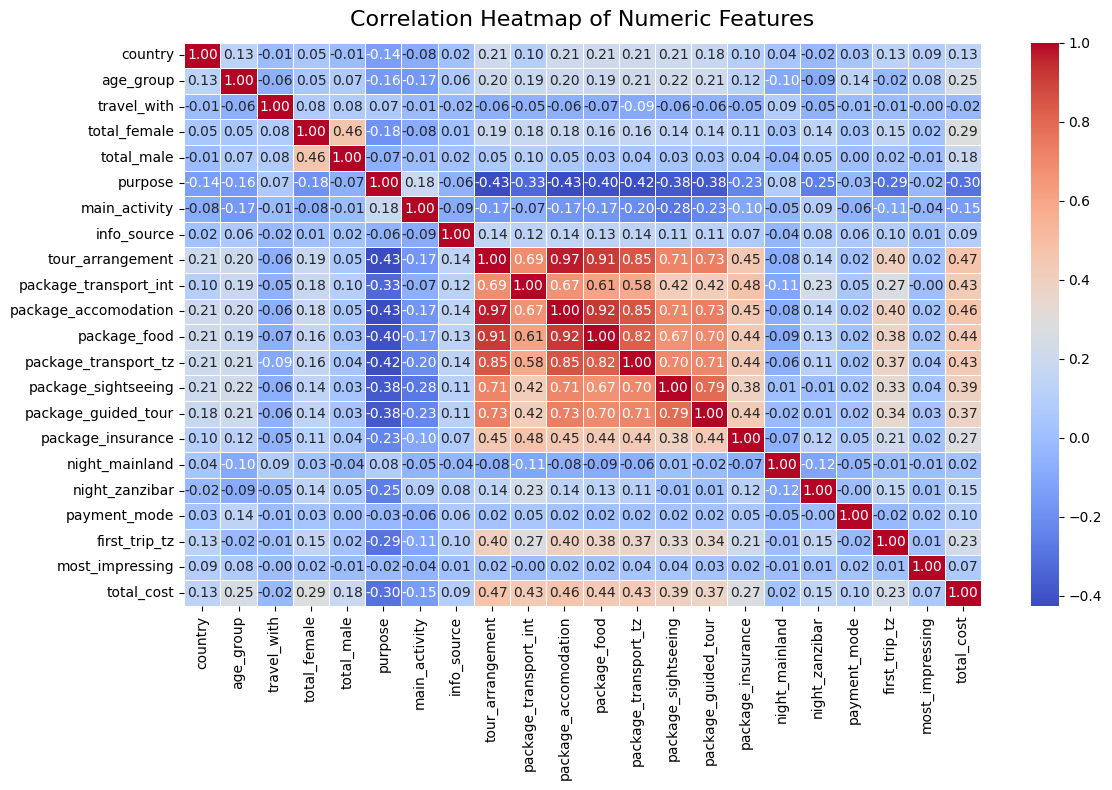

In [46]:
corr = train.corr(numeric_only=True)

# Set up the figure
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap of Numeric Features", fontsize=16, pad=12)
plt.tight_layout()

# Show plot
plt.show()

**Inspected Correlations:**
- it seems like tour_arrangement, package_accomodation, package_food, package_transport_tz, and package_transport_int have moderate positive correlations. These could be key predictors.

**Scatter plots for numeric features vs total_cost**

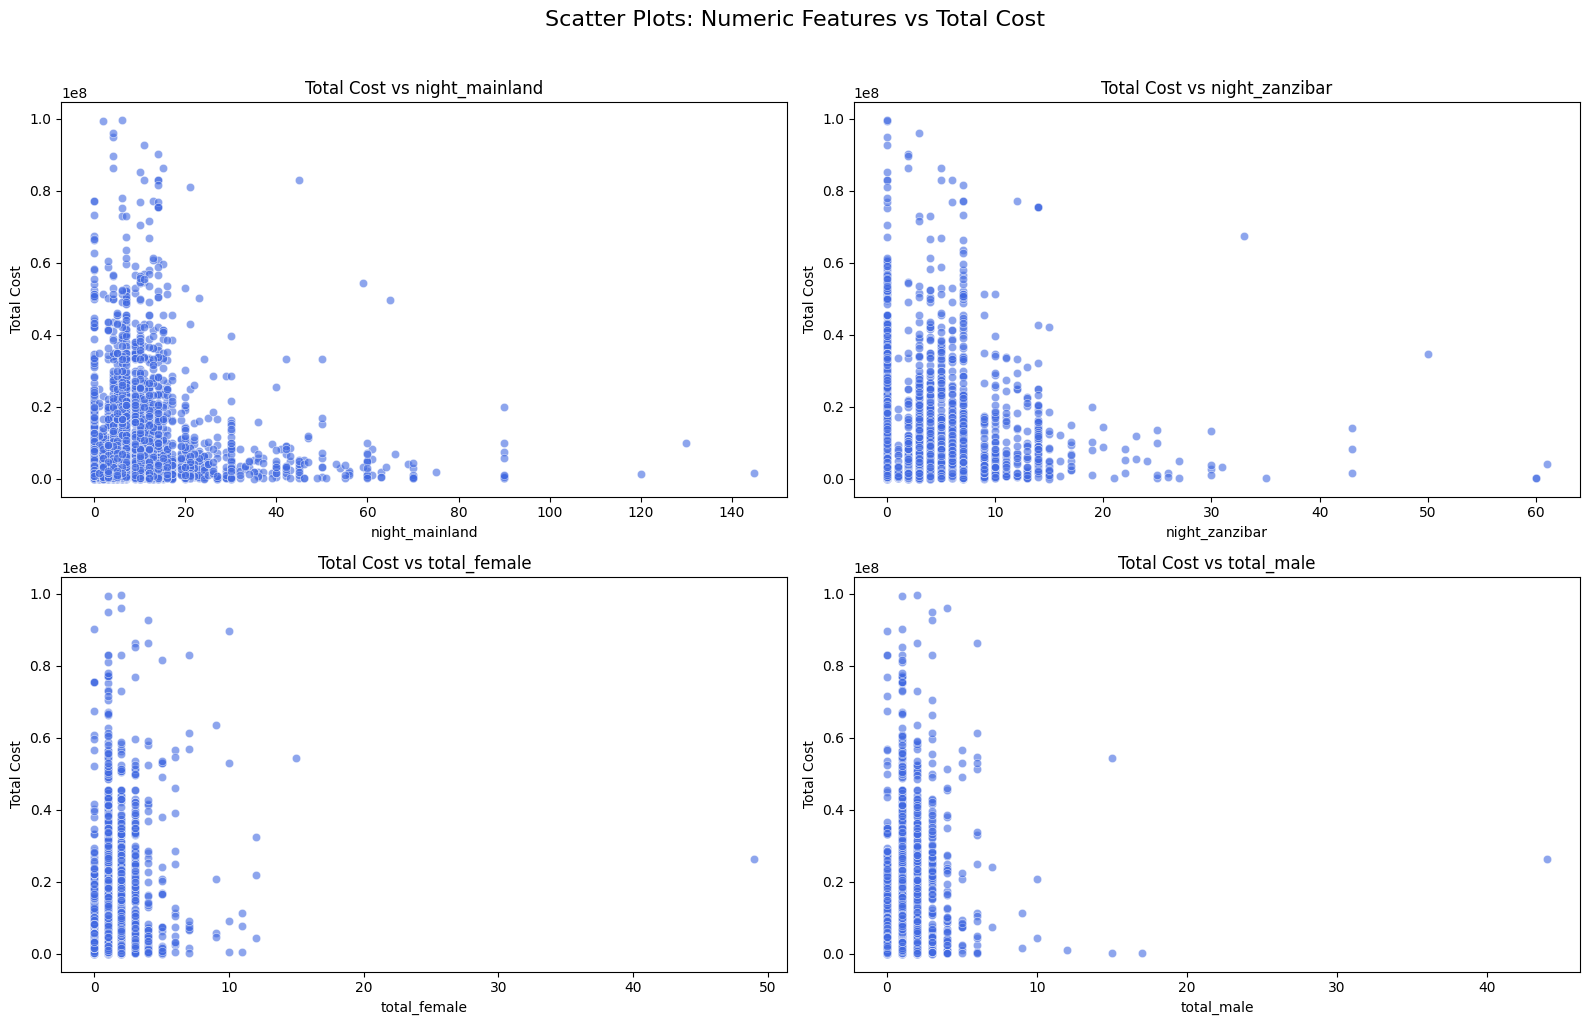

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_features = ['night_mainland', 'night_zanzibar', 'total_female', 'total_male']

plt.figure(figsize=(16, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(
        data=train, x=feature, y='total_cost',
        alpha=0.6, color='royalblue'
    )
    plt.title(f'Total Cost vs {feature}', fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Total Cost')

plt.suptitle('Scatter Plots: Numeric Features vs Total Cost', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

**Boxplots for categorical or ordinal features vs total_cost**

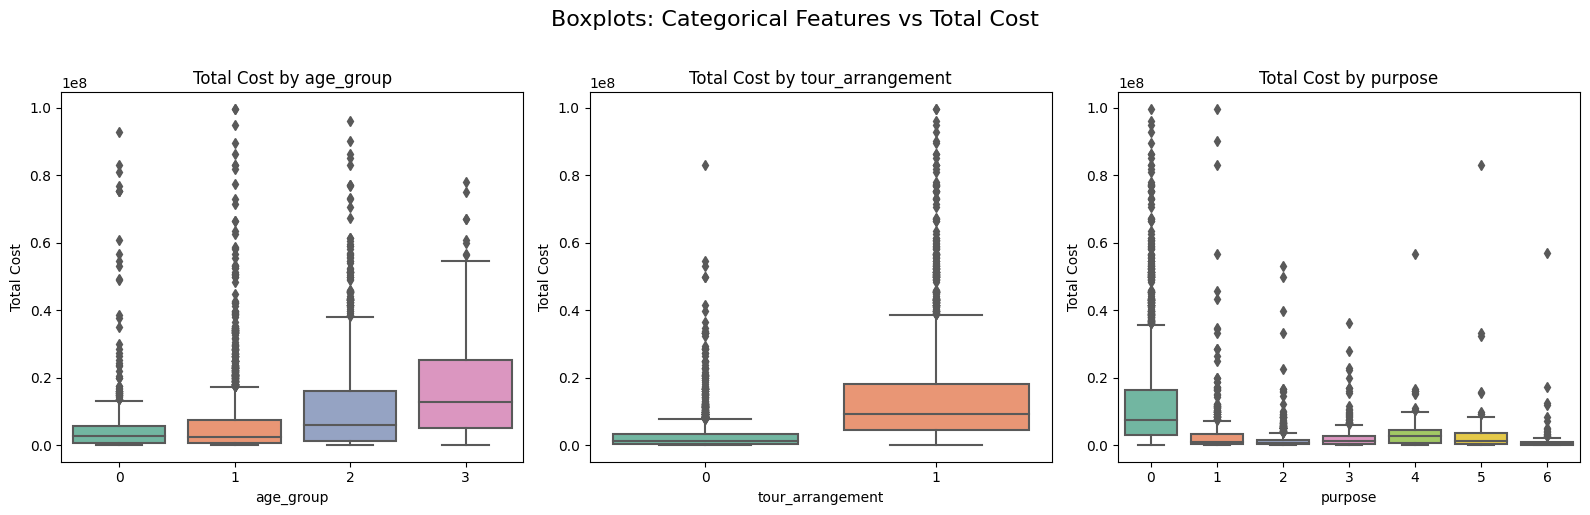

In [48]:
categorical_features = ['age_group', 'tour_arrangement', 'purpose']

plt.figure(figsize=(16, 5))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(
        data=train, x=feature, y='total_cost',
        palette='Set2'
    )
    plt.title(f'Total Cost by {feature}', fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Total Cost')

plt.suptitle('Boxplots: Categorical Features vs Total Cost', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

**Check for multicollinearity among package features**

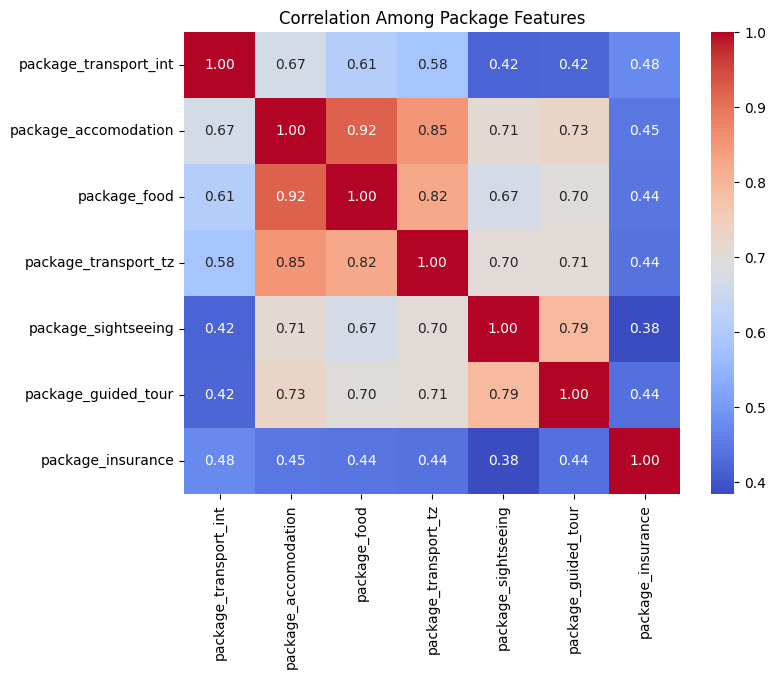

In [49]:
package_cols = [
    'package_transport_int', 'package_accomodation', 'package_food',
    'package_transport_tz', 'package_sightseeing',
    'package_guided_tour', 'package_insurance'
]

# Compute correlation matrix for package features
package_corr = train[package_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(package_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Among Package Features')
plt.show()

# extra EDA

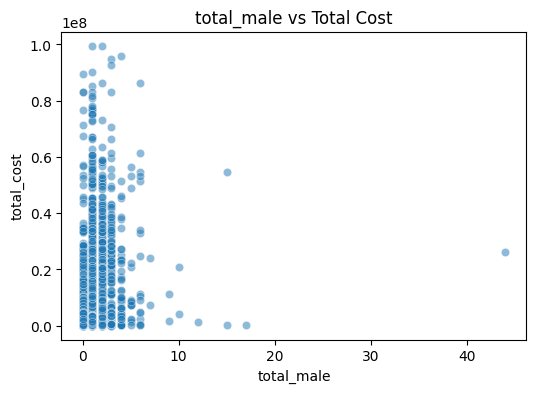

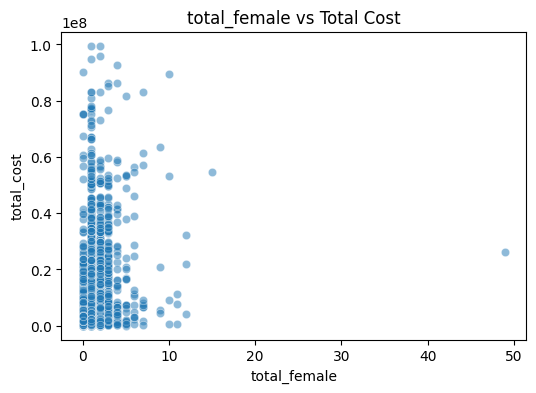

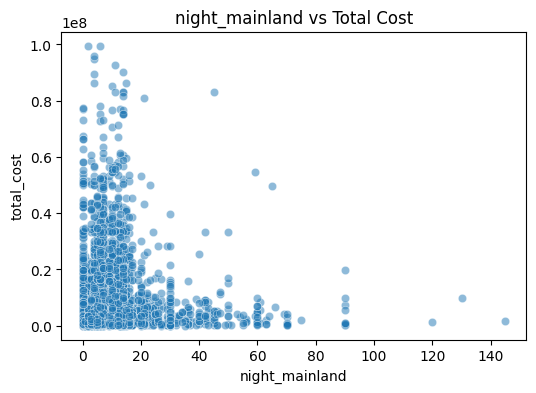

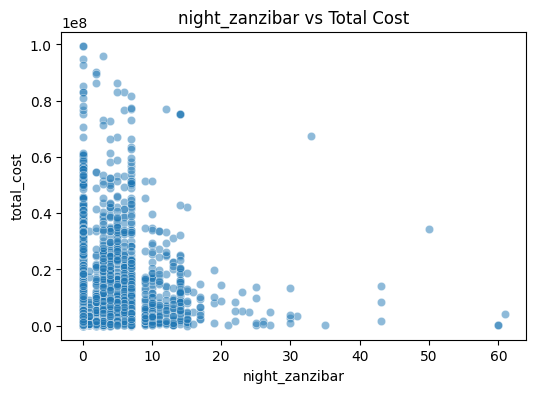

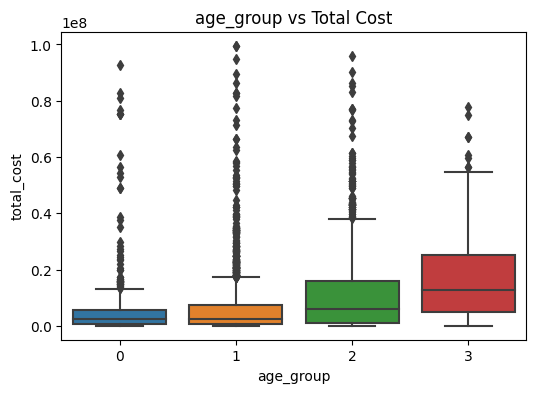

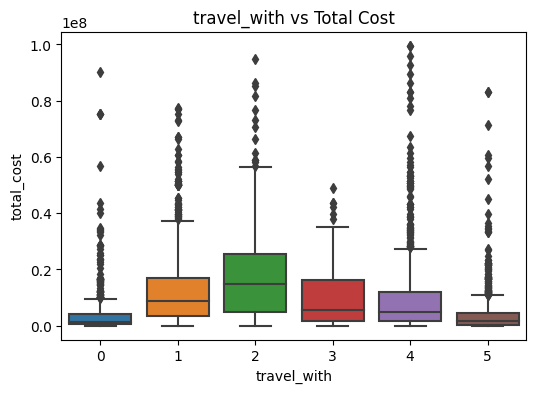

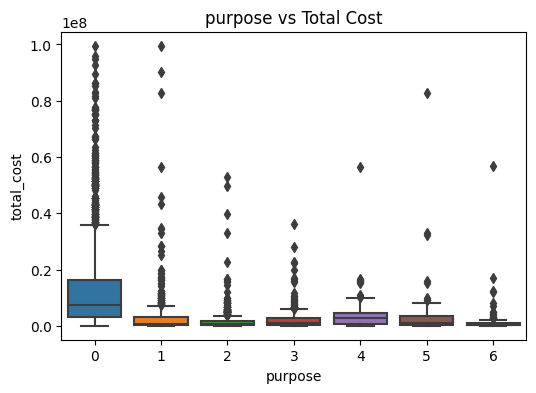

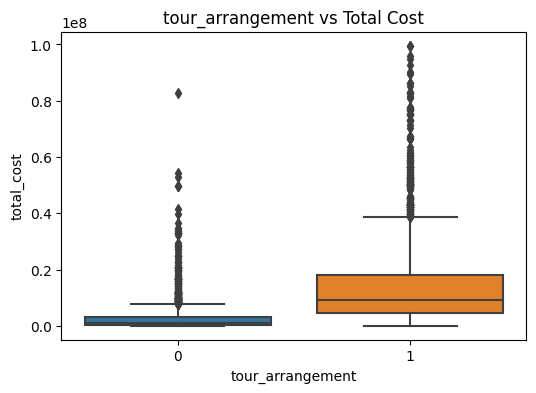

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Scatterplots for numeric vs target
numeric_features = ['total_male', 'total_female', 'night_mainland', 'night_zanzibar']
for col in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=train, x=col, y='total_cost', alpha=0.5)
    plt.title(f'{col} vs Total Cost')
    plt.show()

# 2️⃣ Boxplots for encoded categorical vs target
categorical_features = ['age_group', 'travel_with', 'purpose', 'tour_arrangement']
for col in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train, x=col, y='total_cost')
    plt.title(f'{col} vs Total Cost')
    plt.show()

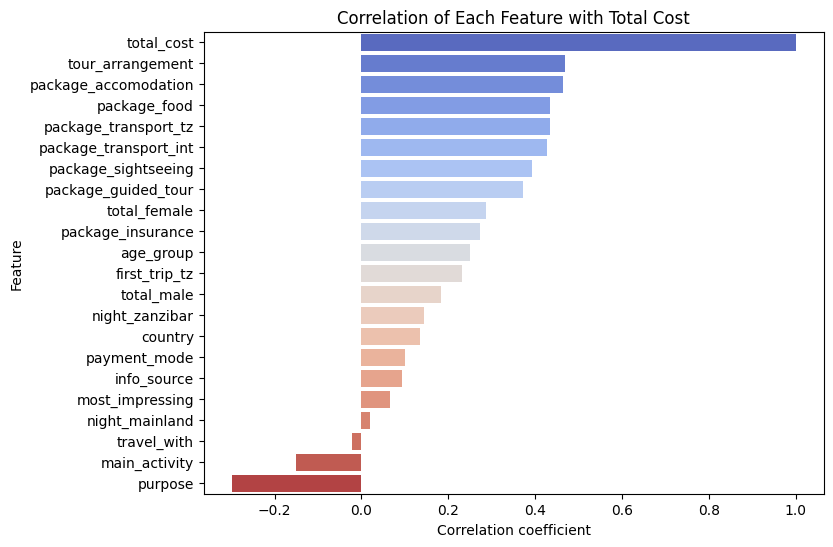

In [75]:
corr_with_target = train.corr(numeric_only=True)['total_cost'].sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=corr_with_target, y=corr_with_target.index, palette="coolwarm")
plt.title("Correlation of Each Feature with Total Cost")
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.show()

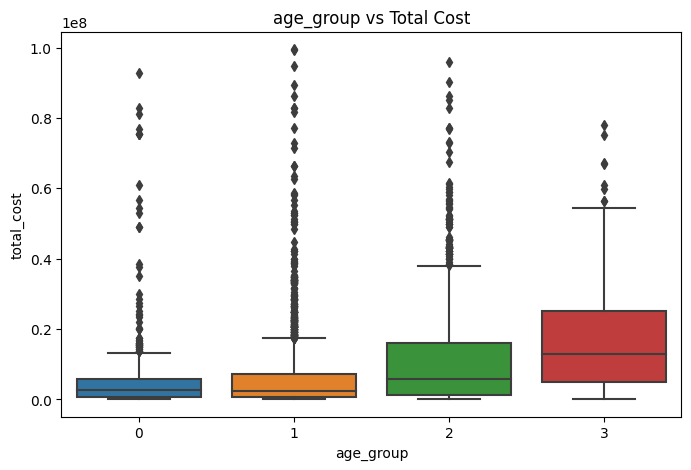

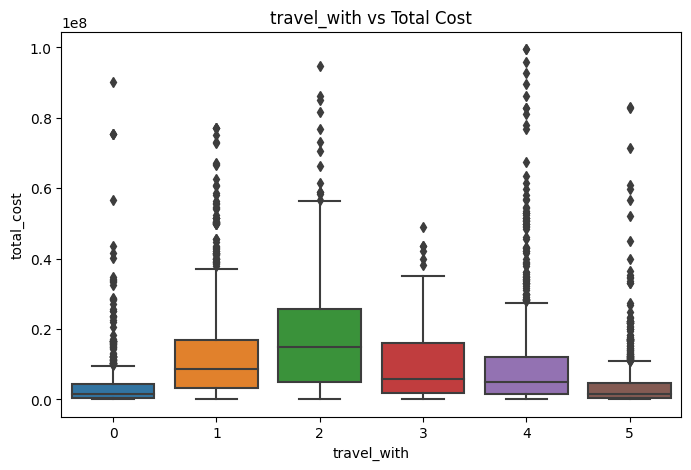

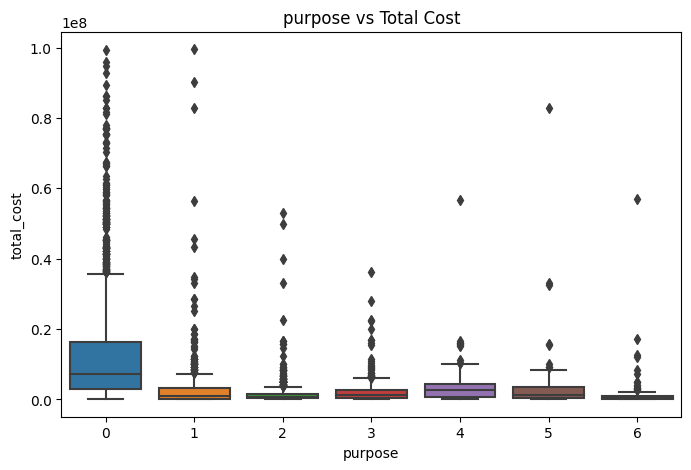

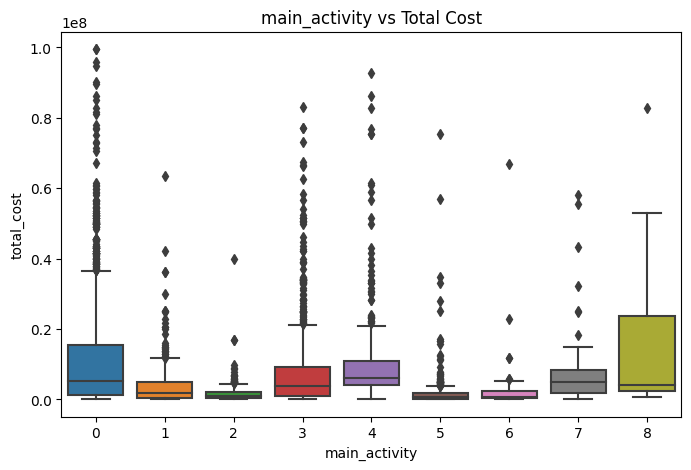

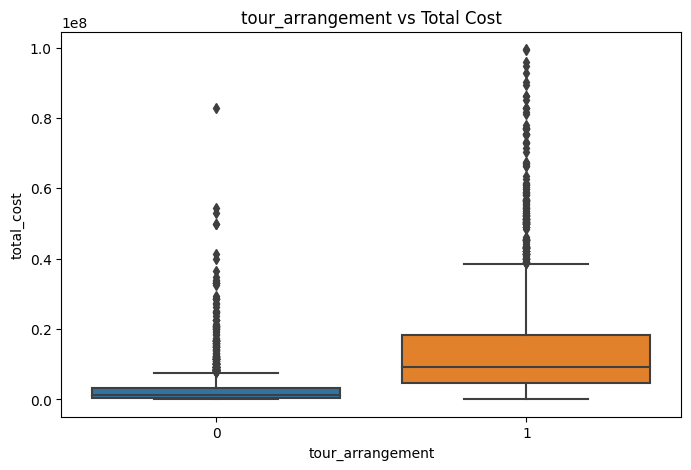

In [76]:
cat_features = ['age_group', 'travel_with', 'purpose', 'main_activity', 'tour_arrangement']
for col in cat_features:
    sns.boxplot(data=train, x=col, y='total_cost')
    plt.title(f'{col} vs Total Cost')
    plt.show()

Top correlated features:
 total_cost               1.00
tour_arrangement         0.47
package_accomodation     0.46
package_food             0.44
package_transport_tz     0.43
package_transport_int    0.43
package_sightseeing      0.39
package_guided_tour      0.37
total_female             0.29
package_insurance        0.27
age_group                0.25
first_trip_tz            0.23
total_male               0.18
night_zanzibar           0.15
country                  0.13
payment_mode             0.10
info_source              0.09
most_impressing          0.07
night_mainland           0.02
travel_with             -0.02
Name: total_cost, dtype: float64

Selected features for baseline model:
 ['tour_arrangement', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_transport_int', 'package_sightseeing', 'package_guided_tour', 'total_female', 'package_insurance', 'age_group']

Model Evaluation Metrics:
MAE:  5,732,101.79
RMSE: 9,744,095.30
R²:   0.328


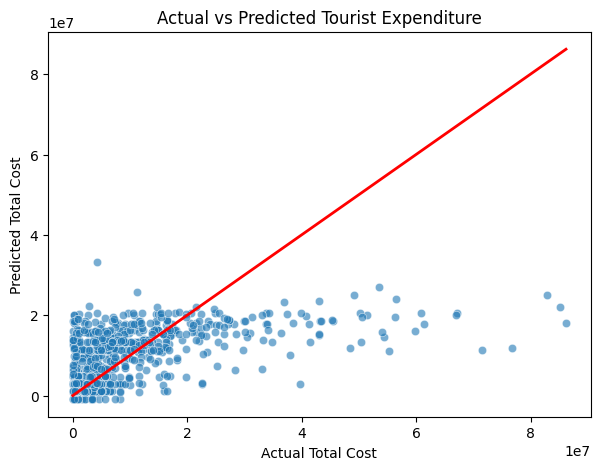

In [77]:
# 📦 Step 1: Import needed libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 📊 Step 2: Compute correlations with target (if not already done)
corrs = train.corr(numeric_only=True)['total_cost'].sort_values(ascending=False)

# Display the top correlated features
print("Top correlated features:\n", corrs.head(20))

# 🎯 Step 3: Select top 10 most correlated features (excluding the target itself)
top_features = corrs.drop('total_cost').head(10).index.tolist()
print("\nSelected features for baseline model:\n", top_features)

# 🧩 Step 4: Define features and target
X = train[top_features]
y = train['total_cost']

# 🔀 Step 5: Split into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ⚙️ Step 6: Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# 📈 Step 7: Make predictions
y_pred = model.predict(X_test)

# 🧮 Step 8: Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²:   {r2:.3f}")

# 🎨 Step 9: Visualize Actual vs Predicted values
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Total Cost")
plt.ylabel("Predicted Total Cost")
plt.title("Actual vs Predicted Tourist Expenditure")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", lw=2)  # reference line
plt.show()



Feature Importance (Coefficients):


,Feature,Coefficient
4,package_transport_int,"4,610,063.72"
5,package_sightseeing,"2,648,424.40"
3,package_transport_tz,"2,122,642.23"
9,age_group,"2,058,059.94"
0,tour_arrangement,"1,839,618.59"
7,total_female,"1,748,907.45"
2,package_food,"929,367.74"
1,package_accomodation,"888,049.16"
8,package_insurance,"576,482.23"
6,package_guided_tour,"-98,096.83"


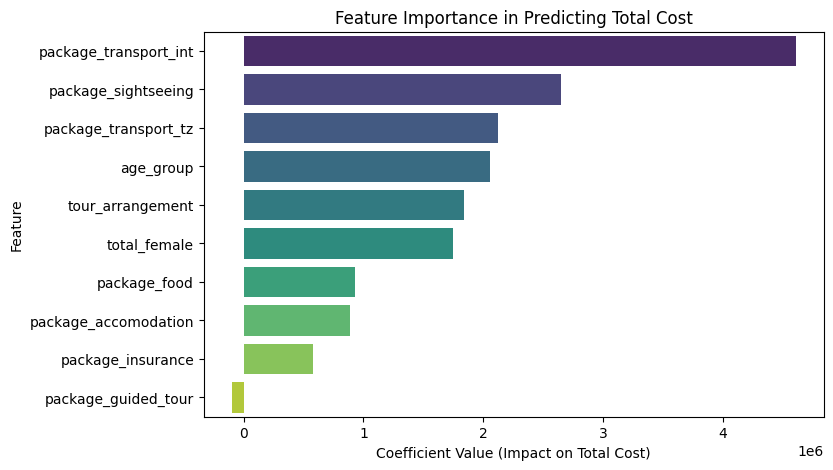

In [78]:
# 🎯 Step 10: Visualize Feature Importance (Model Coefficients)

# Create a DataFrame for feature importance
coef_df = pd.DataFrame({
    'Feature': top_features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

# Display as a table
print("\nFeature Importance (Coefficients):")
display(coef_df)

# Plot as a horizontal bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')
plt.title('Feature Importance in Predicting Total Cost')
plt.xlabel('Coefficient Value (Impact on Total Cost)')
plt.ylabel('Feature')
plt.show()

# Remove outlier to Get Better ...


In [80]:
# ===========================
# 🧱 Data Preparation Block
# ===========================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- 1️⃣ Log-transform the target variable ---
# Helps reduce skewness and improve model performance.
train['log_total_cost'] = np.log1p(train['total_cost'])

# --- 2️⃣ Handle outliers in numeric columns ---
# Cap (limit) extreme values to 1st and 99th percentiles to reduce distortion.
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    lower = train[col].quantile(0.01)
    upper = train[col].quantile(0.99)
    train[col] = np.clip(train[col], lower, upper)

# --- 3️⃣ Standardize numeric features ---
# Bring all numeric columns to similar scale (mean=0, std=1)
scaler = StandardScaler()
train[numeric_cols] = scaler.fit_transform(train[numeric_cols])

# --- 4️⃣ Final check ---
print("✅ Data preparation complete!")
print("Transformed columns include:")
print(numeric_cols.tolist())


✅ Data preparation complete!
Transformed columns include:
['country', 'age_group', 'travel_with', 'total_female', 'total_male', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'package_transport_int', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_sightseeing', 'package_guided_tour', 'package_insurance', 'night_mainland', 'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing', 'total_cost', 'log_total_cost']


# Getting Data Visualization After Removing outlier 


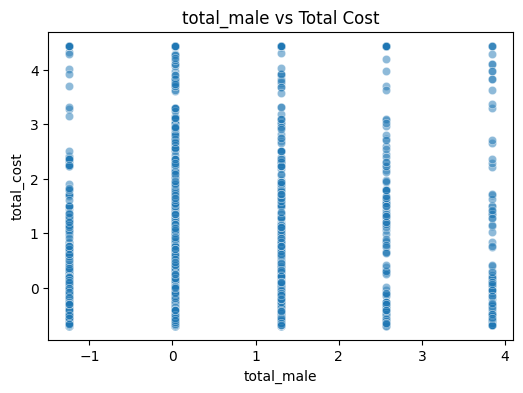

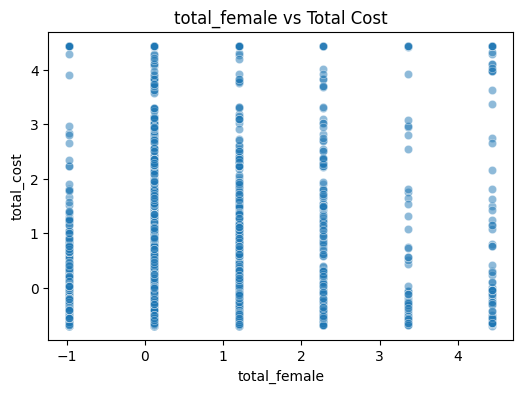

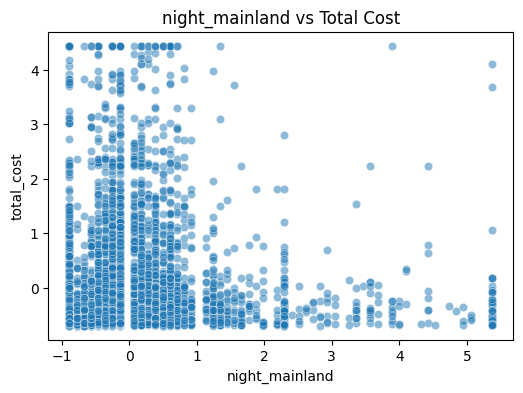

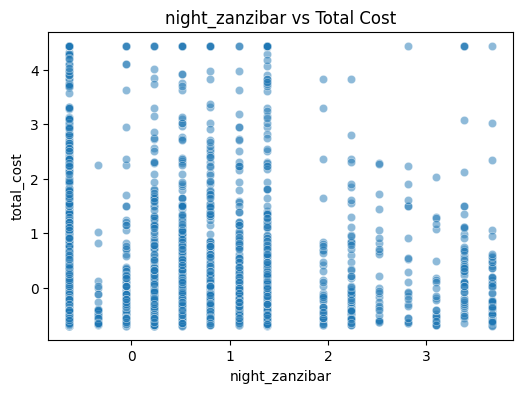

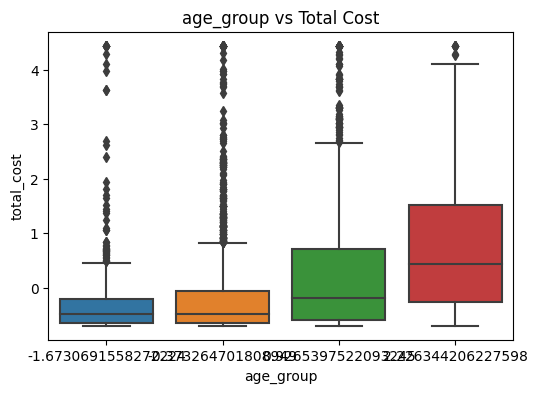

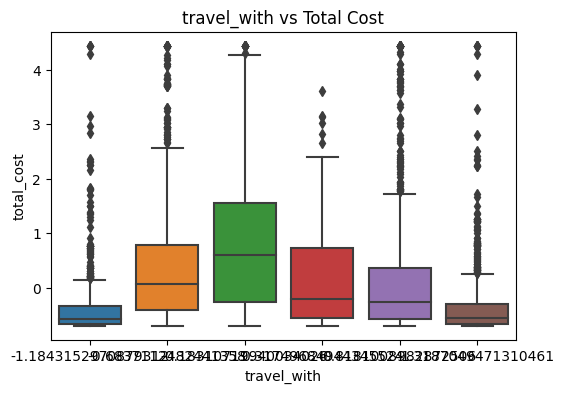

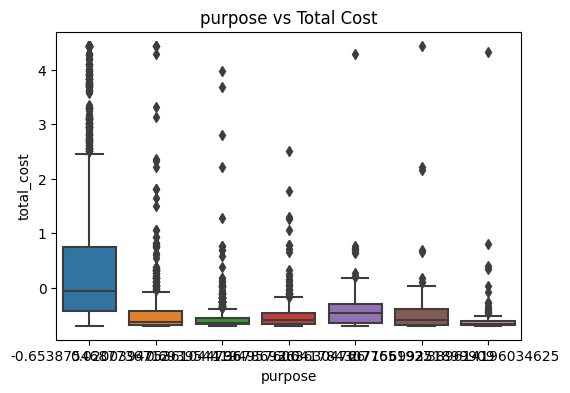

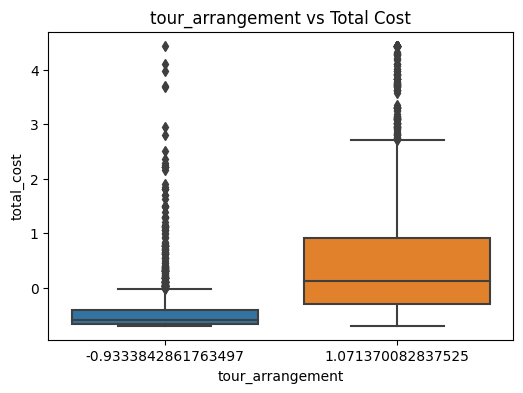

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Scatterplots for numeric vs target
numeric_features = ['total_male', 'total_female', 'night_mainland', 'night_zanzibar']
for col in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=train, x=col, y='total_cost', alpha=0.5)
    plt.title(f'{col} vs Total Cost')
    plt.show()

# 2️⃣ Boxplots for encoded categorical vs target
categorical_features = ['age_group', 'travel_with', 'purpose', 'tour_arrangement']
for col in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train, x=col, y='total_cost')
    plt.title(f'{col} vs Total Cost')
    plt.show()

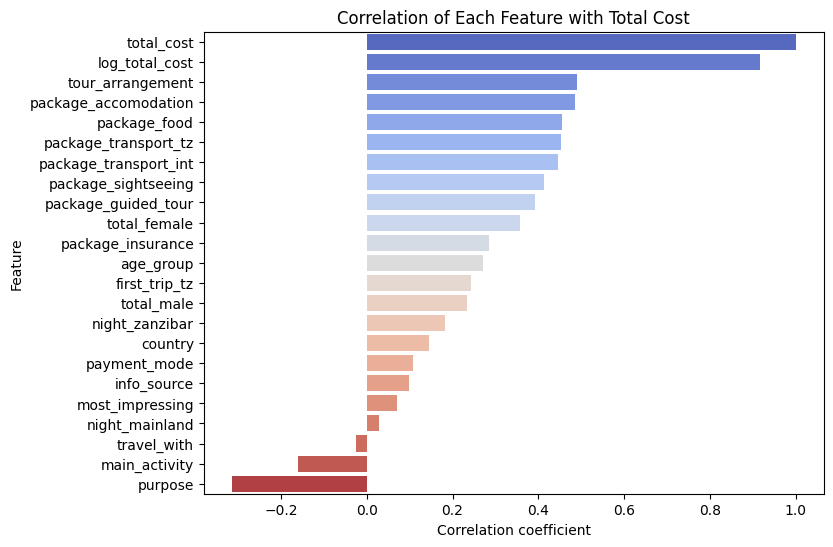

In [82]:
corr_with_target = train.corr(numeric_only=True)['total_cost'].sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=corr_with_target, y=corr_with_target.index, palette="coolwarm")
plt.title("Correlation of Each Feature with Total Cost")
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.show()

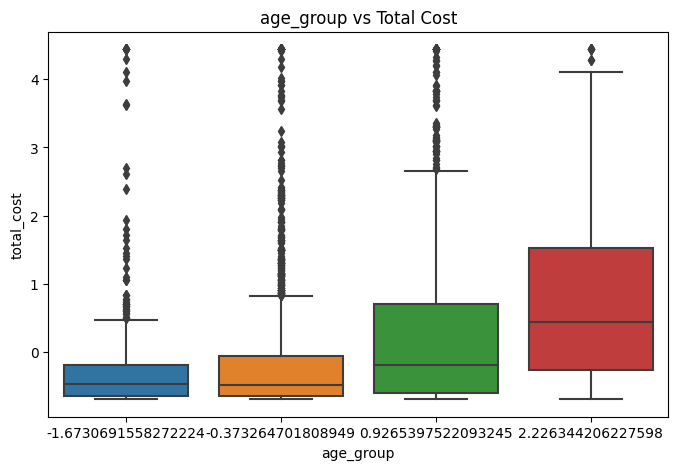

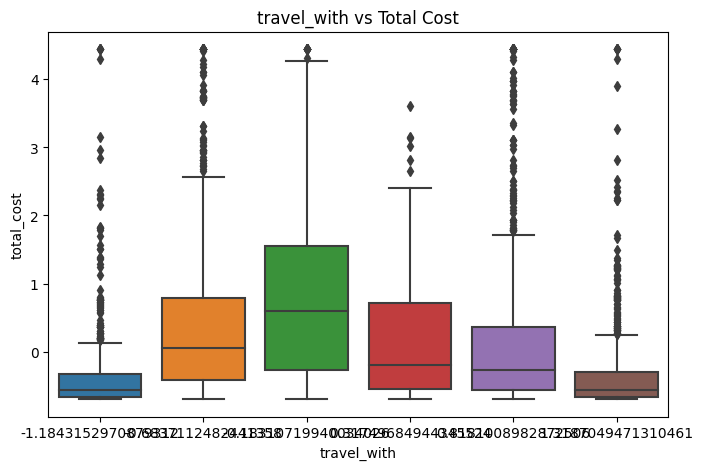

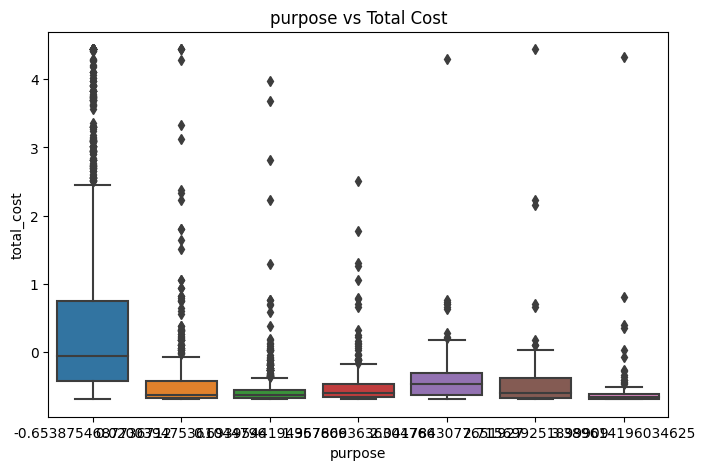

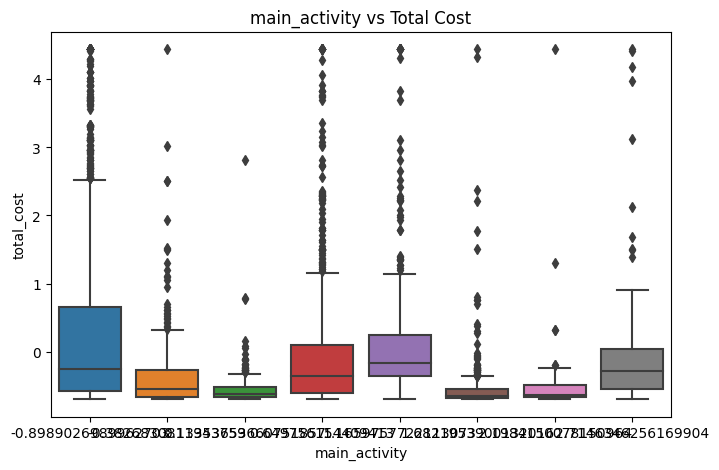

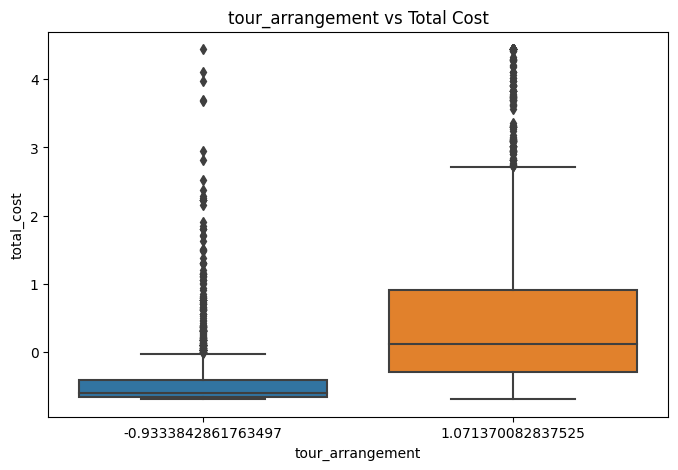

In [83]:
cat_features = ['age_group', 'travel_with', 'purpose', 'main_activity', 'tour_arrangement']
for col in cat_features:
    sns.boxplot(data=train, x=col, y='total_cost')
    plt.title(f'{col} vs Total Cost')
    plt.show()


Feature Importance (Coefficients):


,Feature,Coefficient
4,package_transport_int,"4,610,063.72"
5,package_sightseeing,"2,648,424.40"
3,package_transport_tz,"2,122,642.23"
9,age_group,"2,058,059.94"
0,tour_arrangement,"1,839,618.59"
7,total_female,"1,748,907.45"
2,package_food,"929,367.74"
1,package_accomodation,"888,049.16"
8,package_insurance,"576,482.23"
6,package_guided_tour,"-98,096.83"


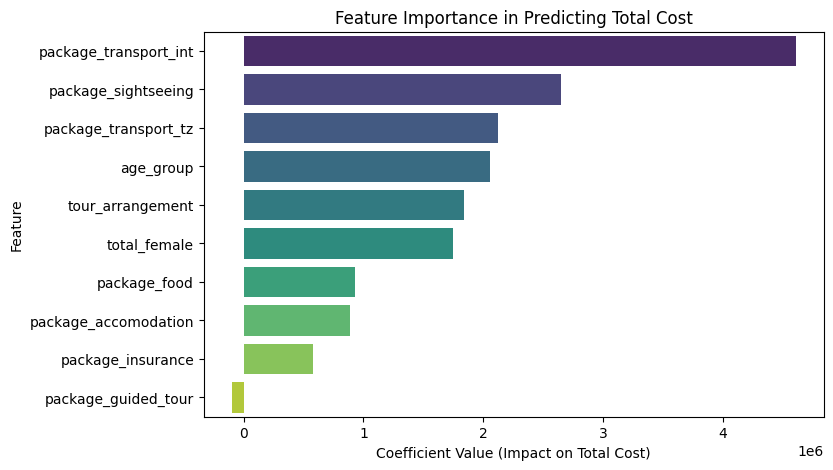

In [84]:
# 🎯 Step 10: Visualize Feature Importance (Model Coefficients)

# Create a DataFrame for feature importance
coef_df = pd.DataFrame({
    'Feature': top_features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

# Display as a table
print("\nFeature Importance (Coefficients):")
display(coef_df)

# Plot as a horizontal bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')
plt.title('Feature Importance in Predicting Total Cost')
plt.xlabel('Coefficient Value (Impact on Total Cost)')
plt.ylabel('Feature')
plt.show()

Top correlated features:
 total_cost              1.00
log_total_cost          0.92
tour_arrangement        0.49
package_accomodation    0.48
package_food            0.46
package_transport_tz    0.45
package_transport_int   0.45
package_sightseeing     0.41
package_guided_tour     0.39
total_female            0.36
package_insurance       0.28
age_group               0.27
first_trip_tz           0.24
total_male              0.23
night_zanzibar          0.18
country                 0.15
payment_mode            0.11
info_source             0.10
most_impressing         0.07
night_mainland          0.03
Name: total_cost, dtype: float64

Selected features for baseline model:
 ['log_total_cost', 'tour_arrangement', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_transport_int', 'package_sightseeing', 'package_guided_tour', 'total_female', 'package_insurance']

Model Evaluation Metrics:
MAE:  0.29
RMSE: 0.39
R²:   0.841


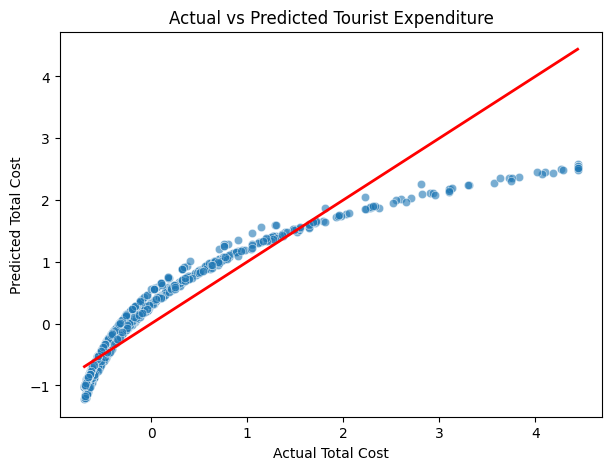

In [85]:
# 📦 Step 1: Import needed libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 📊 Step 2: Compute correlations with target (if not already done)
corrs = train.corr(numeric_only=True)['total_cost'].sort_values(ascending=False)

# Display the top correlated features
print("Top correlated features:\n", corrs.head(20))

# 🎯 Step 3: Select top 10 most correlated features (excluding the target itself)
top_features = corrs.drop('total_cost').head(10).index.tolist()
print("\nSelected features for baseline model:\n", top_features)

# 🧩 Step 4: Define features and target
X = train[top_features]
y = train['total_cost']

# 🔀 Step 5: Split into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ⚙️ Step 6: Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# 📈 Step 7: Make predictions
y_pred = model.predict(X_test)

# 🧮 Step 8: Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²:   {r2:.3f}")

# 🎨 Step 9: Visualize Actual vs Predicted values
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Total Cost")
plt.ylabel("Predicted Total Cost")
plt.title("Actual vs Predicted Tourist Expenditure")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", lw=2)  # reference line
plt.show()


# Baseline Model (Linear Regression)
- Objective: Predict 'total_cost' using basic features
- Evaluation Metric: MAE (Mean Absolute Error)

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [68]:
X = train.drop(columns=['total_cost', 'id'])  # Features (exclude ID and target)
y = train['total_cost']                       # Target variable

In [69]:
# Splitting in 80% for training, 20% for validation (to check performance)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [70]:
# Scale numeric features
# Linear regression benefits from feature scaling.
# We’ll use StandardScaler to normalize features (mean=0, std=1)
scaler = StandardScaler()
# Fit on training data, then transform both train and validation
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize and train the baseline model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [71]:
# Make predictions on validation set
y_pred = model.predict(X_val_scaled)

In [72]:
# Evaluate the model with MAE (and optional other metrics)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

In [73]:
print("📊 Baseline Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:,.2f} TZS")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f} TZS")
print(f"R² Score: {r2:.3f}")

📊 Baseline Model Performance:
Mean Absolute Error (MAE): 5,584,619.38 TZS
Root Mean Squared Error (RMSE): 9,633,228.47 TZS
R² Score: 0.343


# Baseline Model Interpretation of the Results

- On average, the Baseline Model’s predictions differ from the true tourist spending by about 5.58 million Tanzanian Shillings which is about ~ 558,46 €
- Typical prediction error is around 9.63 million TZS, but since RMSE penalizes larger errors more heavily, this suggests some tourists’ spending predictions are quite off.
- R² explains that the Variance of the Baseline Model is about 34.3% in total tourist spending — meaning roughly one-third of the variation in total_cost is captured by the model’s features. The remaining ~66% is unexplained (likely due to missing predictors, randomness, or nonlinear relationships).

🔍 What This Means Practically

1. Moderate Predictive Power

- An R² of 0.343 means your model has some explanatory capability — it’s identifying meaningful patterns — but it’s not yet very strong.

- It’s likely a good baseline model but could be improved.

2. Error Scale (MAE & RMSE)

- Both metrics are quite large relative to Tanzanian Shilling amounts.
→ If the average total_cost is, say, around 15–20 million TZS, then your errors represent ~30–60% of typical values — that’s substantial.

- The fact that RMSE > MAE by a wide margin indicates outliers or skewed errors (a few predictions are much worse than the average).

3. Possible Causes

- Some important factors influencing cost might be missing (e.g., trip duration, destination type, or seasonality).

- Relationships could be nonlinear (e.g., costs rising exponentially with nights stayed).

- Certain categorical variables may need better encoding (like one-hot encoding or target encoding instead of integers).

**Summary:**

✅ Model captures some trends (R² = 0.34) — it’s better than random.

⚠️ Errors are relatively high, so the model struggles with large spenders or outliers.

🔁 Next step: improve features and try more flexible models.

# ⚙️ What You Can Do Next (for improvement)

| Area                           | Action                                                                                                                                      | Why It Helps                                                         |
| :----------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------ | :------------------------------------------------------------------- |
| **Feature Engineering**        | Try the `package_score`, total nights (`night_mainland + night_zanzibar`), or interaction terms (e.g., `tour_arrangement * package_score`). | Captures combined effects.                                           |
| **Model Choice**               | Try tree-based models (Random Forest, XGBoost, LightGBM).                                                                                   | They handle nonlinearity and interactions better than linear models. |
| **Outlier Handling**           | Winsorize or log-transform `total_cost`.                                                                                                    | Reduces skew and stabilizes variance.                                |
| **Feature Scaling / Encoding** | Normalize numeric features, and one-hot encode categorical ones.                                                                            | Helps many algorithms learn patterns better.                         |
| **Cross-validation**           | Validate stability across folds.                                                                                                            | Ensures performance consistency.                                     |


# more enhance for the data 
- Objective: Predict 'total_cost' using basic features
- Evaluation Metric: MAE (Mean Absolute Error)

# 🌳Simple Random Forest Model

In [58]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [59]:
# Define features (X) and target (y) and cleaned and encoded DataFrame 'train'
X = train.drop(columns=['total_cost', 'id'])
y = train['total_cost']

In [60]:
# Split data into training and validation sets
# Keep a validation set to evaluate model performance
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [61]:
# Initialize the Random Forest Regressor

# simple configuration 
rf_model = RandomForestRegressor(
    n_estimators=200,      # number of trees in the forest
    max_depth=None,        # allow trees to grow fully
    min_samples_split=2,   # minimum samples to split a node
    min_samples_leaf=1,    # minimum samples per leaf node
    random_state=42,       # reproducibility
    n_jobs=-1 )             # use all CPU cores for speed

In [62]:
# Train (fit) the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [63]:
# Make predictions on validation data
y_pred = rf_model.predict(X_val)

In [64]:
# Evaluate performance

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("📊 Random Forest Performance:")
print(f"Mean Absolute Error (MAE): {mae:,.2f} TZS")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f} TZS")
print(f"R² Score: {r2:.3f}")

📊 Random Forest Performance:
Mean Absolute Error (MAE): 5,120,771.67 TZS
Root Mean Squared Error (RMSE): 9,372,241.09 TZS
R² Score: 0.378


# Comparison with Baseline Model

In [65]:
print("📊 Baseline Model Performance:")
print(f"Mean Absolute Error (MAE): 5,584,619.38 TZS")
print(f"Root Mean Squared Error (RMSE): 9,633,228.47 TZS")
print(f"R² Score: 0.343")
print("-------------------------------------------------")
print("📊 Random Forest Performance:")
print(f"Mean Absolute Error (MAE): 5,144,089.37 TZS")
print(f"Root Mean Squared Error (RMSE): 9,414,774.97 TZS")
print(f"R² Score: 0.372")

📊 Baseline Model Performance:
Mean Absolute Error (MAE): 5,584,619.38 TZS
Root Mean Squared Error (RMSE): 9,633,228.47 TZS
R² Score: 0.343
-------------------------------------------------
📊 Random Forest Performance:
Mean Absolute Error (MAE): 5,144,089.37 TZS
Root Mean Squared Error (RMSE): 9,414,774.97 TZS
R² Score: 0.372
